# Predicting future energy usage from multiple dependent time series

For updates on the way Sagemaker or AWS behave compared to the notebook code, please refer to https://livebook.manning.com/#!/book/machine-learning-for-business/chapter-6/v-5/102

## Part 1: Load and examine the data

In [1]:
data_bucket = 'mlforbusiness'
subfolder = 'ch06'

In [2]:
%matplotlib inline

from dateutil.parser import parse
import json
from random import shuffle
import random
import datetime
import os
from time import sleep

import pandas as pd                               
import boto3
import s3fs
import sagemaker
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

role = sagemaker.get_execution_role()
s3 = s3fs.S3FileSystem(anon=False)

In [3]:
s3_data_path = f"s3://{data_bucket}/{subfolder}/data"
s3_output_path = f"s3://{data_bucket}/{subfolder}/output"
df = pd.read_csv(f's3://{data_bucket}/{subfolder}/meter_data.csv', index_col=0)
df.head()

,Site_1,Site_2,Site_3,Site_4,Site_5,Site_6,Site_7,Site_8,Site_9,Site_10,...,Site_39,Site_40,Site_41,Site_42,Site_43,Site_44,Site_45,Site_47,Site_46,Site_48
2017-11-01 00:00:00,13.30,13.3,11.68,13.02,0.0,102.9,11.4,21.8,9.7,11.9,...,22.20,0.0,0.0,0,23.30,36.74,48.48,68.70,32.13,19.39
2017-11-01 00:30:00,11.75,11.9,12.63,13.36,0.0,122.1,11.3,17.7,9.0,12.4,...,21.68,0.0,0.0,0,22.14,36.44,50.18,69.09,29.02,19.54
2017-11-01 01:00:00,12.58,11.4,11.86,13.04,0.0,110.3,10.9,17.5,9.1,12.0,...,21.56,0.0,0.0,0,21.88,35.93,49.44,67.52,26.65,20.10
2017-11-01 01:30:00,12.50,10.8,11.53,11.83,0.0,83.6,11.2,16.5,12.4,11.5,...,21.28,0.0,0.0,0,22.69,45.25,49.57,68.48,25.28,19.46
2017-11-01 02:00:00,12.98,12.0,11.57,12.25,0.0,91.4,10.9,16.3,12.4,11.3,...,40.48,0.0,0.0,0,22.75,62.94,48.58,75.30,23.65,19.18


In [4]:
print(f'Number of rows in dataset: {df.shape[0]}')
print(f'Number of columns in dataset: {df.shape[1]}')

Number of rows in dataset: 19632
Number of columns in dataset: 48


## Part 2 : Get the data in the right shape

In [5]:
df.index = pd.to_datetime(df.index)
daily_df = df.resample('D').sum()
daily_df.head()

,Site_1,Site_2,Site_3,Site_4,Site_5,Site_6,Site_7,Site_8,Site_9,Site_10,...,Site_39,Site_40,Site_41,Site_42,Site_43,Site_44,Site_45,Site_47,Site_46,Site_48
2017-11-01,1184.23,1039.1,985.95,1205.07,0.0,6684.4,1192.1,1256.1,982.6,1001.4,...,1548.92,0.0,0.0,0,1573.23,2871.58,2303.38,2977.41,2672.10,2298.95
2017-11-02,1210.90,1084.7,1013.91,1252.44,0.0,6894.3,1238.6,1249.4,1023.6,997.4,...,1539.52,0.0,0.0,0,1537.35,2890.60,2290.59,2988.84,2658.95,2112.39
2017-11-03,1247.60,1004.2,963.95,1222.40,0.0,6841.0,1174.3,1210.3,990.3,1009.3,...,1487.40,0.0,0.0,0,1615.69,2737.92,2289.75,2898.06,2642.38,2475.31
2017-11-04,1246.92,936.2,877.97,1157.45,0.0,6079.1,1041.2,1086.7,879.3,854.7,...,325.96,0.0,0.0,0,888.55,1726.20,2127.39,2617.02,1429.63,564.29
2017-11-05,1189.20,830.8,798.97,975.69,0.0,5221.5,929.4,1068.0,767.7,785.8,...,318.24,0.0,0.0,0,867.91,1849.85,2124.23,2320.60,726.15,554.00


In [6]:
print(daily_df.shape)
print(f'Time series starts at {daily_df.index[0]} and ends at {daily_df.index[-1]}')

(409, 48)
Time series starts at 2017-11-01 00:00:00 and ends at 2018-12-14 00:00:00


In [7]:
daily_df = daily_df.fillna(daily_df.shift(7))
daily_df

,Site_1,Site_2,Site_3,Site_4,Site_5,Site_6,Site_7,Site_8,Site_9,Site_10,...,Site_39,Site_40,Site_41,Site_42,Site_43,Site_44,Site_45,Site_47,Site_46,Site_48
2017-11-01,1184.23,1039.1,985.95,1205.07,0.0,6684.4,1192.1,1256.1,982.6,1001.4,...,1548.92,0.0,0.0,0,1573.23,2871.58,2303.38,2977.41,2672.10,2298.95
2017-11-02,1210.90,1084.7,1013.91,1252.44,0.0,6894.3,1238.6,1249.4,1023.6,997.4,...,1539.52,0.0,0.0,0,1537.35,2890.60,2290.59,2988.84,2658.95,2112.39
2017-11-03,1247.60,1004.2,963.95,1222.40,0.0,6841.0,1174.3,1210.3,990.3,1009.3,...,1487.40,0.0,0.0,0,1615.69,2737.92,2289.75,2898.06,2642.38,2475.31
2017-11-04,1246.92,936.2,877.97,1157.45,0.0,6079.1,1041.2,1086.7,879.3,854.7,...,325.96,0.0,0.0,0,888.55,1726.20,2127.39,2617.02,1429.63,564.29
2017-11-05,1189.20,830.8,798.97,975.69,0.0,5221.5,929.4,1068.0,767.7,785.8,...,318.24,0.0,0.0,0,867.91,1849.85,2124.23,2320.60,726.15,554.00
2017-11-06,1143.62,1004.1,1059.26,1203.49,0.0,6899.1,1159.1,1272.6,971.6,972.0,...,1465.64,0.0,0.0,0,1473.89,2834.13,2266.99,2881.72,2556.36,2517.31
2017-11-07,1145.66,1054.9,972.12,1217.02,0.0,6525.1,1157.8,1210.7,991.2,988.2,...,1551.48,0.0,0.0,0,1527.13,2800.96,2264.15,2586.15,943.05,2375.63
2017-11-08,1165.50,1121.6,978.04,1206.09,0.0,6832.6,1183.5,1253.8,994.0,999.6,...,1544.20,0.0,0.0,0,1542.24,2814.11,2292.10,2740.60,2686.35,2877.74
2017-11-09,1239.25,1117.8,1051.85,1294.36,0.0,7173.4,1260.7,1394.8,1162.6,1078.4,...,1516.12,0.0,0.0,0,1661.60,2875.76,2265.78,2572.84,2558.79,2432.99
2017-11-10,1366.25,1188.6,1187.58,1331.94,0.0,7596.4,1280.7,1404.2,1155.5,1174.7,...,1486.20,0.0,0.0,0,1571.27,2753.92,2279.95,2452.62,2620.67,2894.41


Number of time series: 48


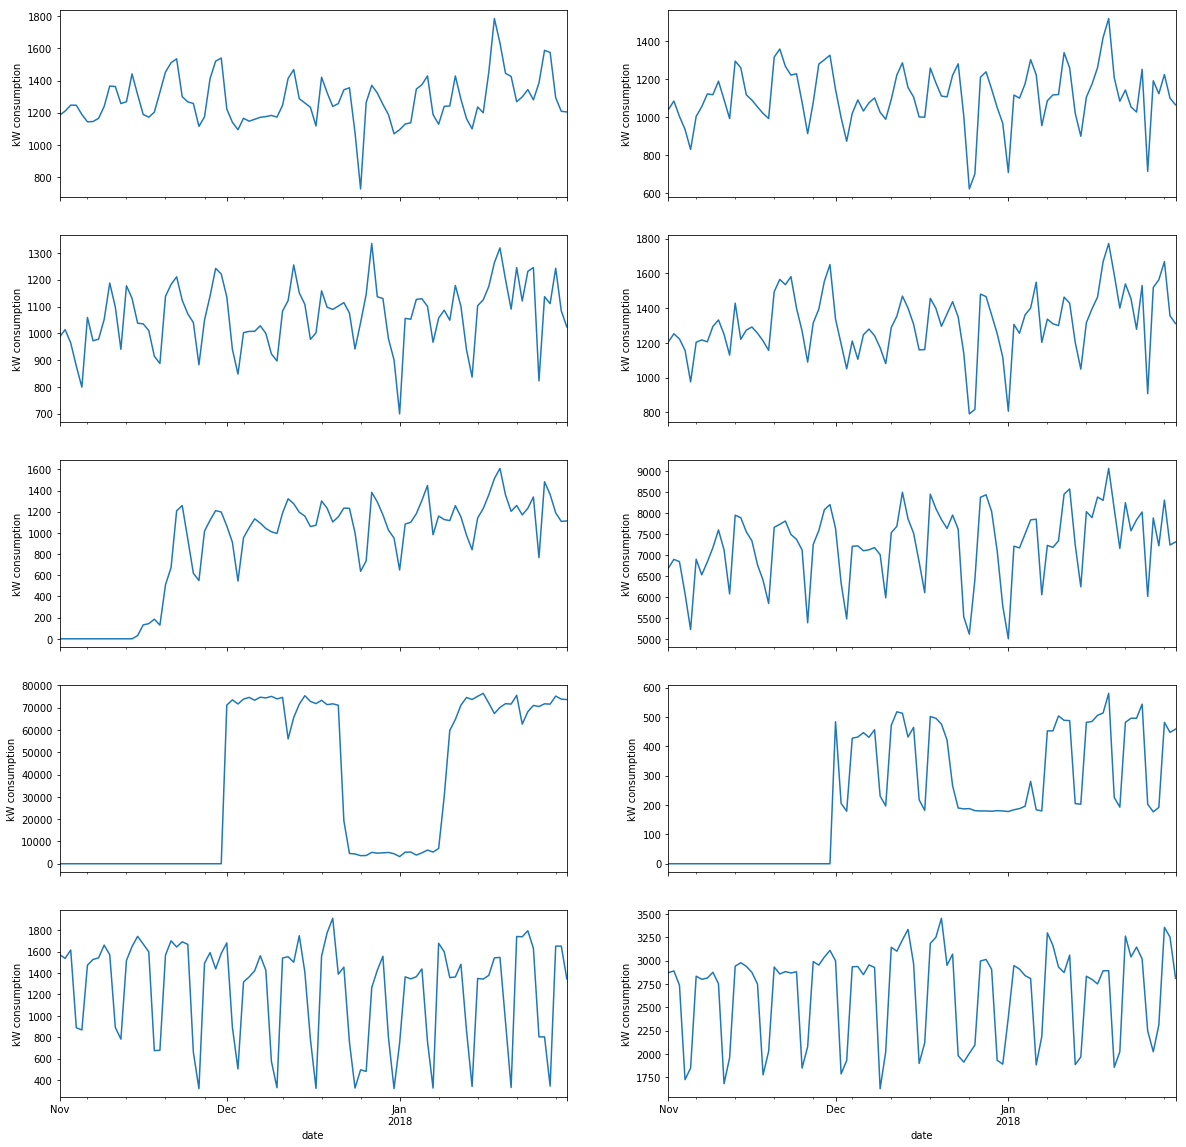

In [8]:
print('Number of time series:',daily_df.shape[1])
fig, axs = plt.subplots(5, 2, figsize=(20, 20), sharex=True)
axx = axs.ravel()
indices = [0,1,2,3,4,5,40,41,42,43]
for i in indices:
    plot_num = indices.index(i)
    daily_df[daily_df.columns[i]].loc["2017-11-01":"2018-01-31"].plot(ax=axx[plot_num])
    axx[plot_num].set_xlabel("date")    
    axx[plot_num].set_ylabel("kW consumption")

Visually there are some noticeable correlations which DeepAR will likely recognise and use!

## Part 3: Create Train and Test Datasets

In [9]:
daily_power_consumption_per_site = []
for column in daily_df.columns:
    site_consumption = np.trim_zeros(daily_df[column], trim='f')
    site_consumption = site_consumption.fillna(0)
    daily_power_consumption_per_site.append(site_consumption)
    
print(f'Time series covers {len(daily_power_consumption_per_site[0])} days.')
print(f'Time series starts at {daily_power_consumption_per_site[0].index[0]}')
print(f'Time series ends at {daily_power_consumption_per_site[0].index[-1]}') 

Time series covers 409 days.
Time series starts at 2017-11-01 00:00:00
Time series ends at 2018-12-14 00:00:00


In [12]:
freq = 'D'
prediction_length = 30

start_date = pd.Timestamp("2017-11-01 00:00:00", freq=freq)
end_training = start_date + 364 * start_date.freq
end_testing = end_training + prediction_length * start_date.freq

print(f'End training: {end_training}, End testing: {end_testing}')

End training: 2018-10-31 00:00:00, End testing: 2018-11-30 00:00:00


In [13]:
training_data = [
    {
        "start": str(start_date),
        "target": ts[start_date:end_training].tolist()
    }
    for ts in daily_power_consumption_per_site
]

test_data = [
    {
        "start": str(start_date),
        "target": ts[start_date:end_testing].tolist()
    }
    for ts in daily_power_consumption_per_site
]

In [14]:
def write_dicts_to_s3(path, data):
    with s3.open(path, 'wb') as f:
        for d in data:
            f.write(json.dumps(d).encode("utf-8"))
            f.write("\n".encode('utf-8'))
            
write_dicts_to_s3(f'{s3_data_path}/train/train.json', training_data)
write_dicts_to_s3(f'{s3_data_path}/test/test.json', test_data)

## Part 4: Train the Model

In [15]:
s3_output_path = f's3://{data_bucket}/{subfolder}/output'
sess = sagemaker.Session()
image_name = sagemaker.amazon.amazon_estimator.get_image_uri(sess.boto_region_name, "forecasting-deepar", "latest")

In [17]:
estimator = sagemaker.estimator.Estimator(
    sagemaker_session=sess,
    image_name=image_name,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.m4.xlarge',
    base_job_name='ch6-energy-usage',
    output_path=s3_output_path
)

In [18]:
estimator.set_hyperparameters(
    time_freq=freq,
    epochs="400",
    early_stopping_patience="40",
    mini_batch_size="64",
    learning_rate="5E-4",
    context_length="90",
    prediction_length=str(prediction_length)
)

In [19]:
%%time
data_channels = {
    "train": "{}/train/".format(s3_data_path),
    "test": "{}/test/".format(s3_data_path)
}
estimator.fit(inputs=data_channels, wait=True)

2019-07-06 08:35:35 Starting - Starting the training job...
2019-07-06 08:35:38 Starting - Launching requested ML instances......
2019-07-06 08:36:38 Starting - Preparing the instances for training......
2019-07-06 08:37:54 Downloading - Downloading input data...
2019-07-06 08:38:27 Training - Downloading the training image..
Arguments: train
[07/06/2019 08:38:48 INFO 140570225399616] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'auto', u'likelihood': u'student-t', u'early_stopping_patience': u''}
[07/06/2019 08:38:

[07/06/2019 08:39:01 INFO 140570225399616] Epoch[5] Batch[0] avg_epoch_loss=6.950469
[07/06/2019 08:39:01 INFO 140570225399616] #quality_metric: host=algo-1, epoch=5, batch=0 train loss <loss>=6.95046854019
[07/06/2019 08:39:02 INFO 140570225399616] Epoch[5] Batch[5] avg_epoch_loss=6.974223
[07/06/2019 08:39:02 INFO 140570225399616] #quality_metric: host=algo-1, epoch=5, batch=5 train loss <loss>=6.97422281901
[07/06/2019 08:39:02 INFO 140570225399616] Epoch[5] Batch [5]#011Speed: 350.67 samples/sec#011loss=6.974223
[07/06/2019 08:39:03 INFO 140570225399616] Epoch[5] Batch[10] avg_epoch_loss=6.993421
[07/06/2019 08:39:03 INFO 140570225399616] #quality_metric: host=algo-1, epoch=5, batch=10 train loss <loss>=7.01645917892
[07/06/2019 08:39:03 INFO 140570225399616] Epoch[5] Batch [10]#011Speed: 362.39 samples/sec#011loss=7.016459
[07/06/2019 08:39:03 INFO 140570225399616] processed a total of 705 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 2352.515935897827, "sum": 

[07/06/2019 08:39:21 INFO 140570225399616] processed a total of 600 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1984.8101139068604, "sum": 1984.8101139068604, "min": 1984.8101139068604}}, "EndTime": 1562402361.954385, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1562402359.969509}

[07/06/2019 08:39:21 INFO 140570225399616] #throughput_metric: host=algo-1, train throughput=302.276893865 records/second
[07/06/2019 08:39:21 INFO 140570225399616] #progress_metric: host=algo-1, completed 3 % of epochs
[07/06/2019 08:39:21 INFO 140570225399616] #quality_metric: host=algo-1, epoch=14, train loss <loss>=6.56388697624
[07/06/2019 08:39:21 INFO 140570225399616] best epoch loss so far
[07/06/2019 08:39:22 INFO 140570225399616] Saved checkpoint to "/opt/ml/model/state_6f9afee0-509d-470b-9c68-62945e8bc1ae-0000.params"
#metrics {"Metrics": {"state.serialize.time": {"count": 1, "max": 45.153141021728516, "sum": 45.1531410217

[07/06/2019 08:39:42 INFO 140570225399616] Epoch[24] Batch[5] avg_epoch_loss=6.426234
[07/06/2019 08:39:42 INFO 140570225399616] #quality_metric: host=algo-1, epoch=24, batch=5 train loss <loss>=6.42623360952
[07/06/2019 08:39:42 INFO 140570225399616] Epoch[24] Batch [5]#011Speed: 362.99 samples/sec#011loss=6.426234
[07/06/2019 08:39:42 INFO 140570225399616] processed a total of 629 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1966.1998748779297, "sum": 1966.1998748779297, "min": 1966.1998748779297}}, "EndTime": 1562402382.876353, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1562402380.909486}

[07/06/2019 08:39:42 INFO 140570225399616] #throughput_metric: host=algo-1, train throughput=319.88494984 records/second
[07/06/2019 08:39:42 INFO 140570225399616] #progress_metric: host=algo-1, completed 6 % of epochs
[07/06/2019 08:39:42 INFO 140570225399616] #quality_metric: host=algo-1, epoch=24, train loss <loss>=6.3

[07/06/2019 08:40:01 INFO 140570225399616] Epoch[34] Batch[0] avg_epoch_loss=6.050859
[07/06/2019 08:40:01 INFO 140570225399616] #quality_metric: host=algo-1, epoch=34, batch=0 train loss <loss>=6.05085897446
[07/06/2019 08:40:02 INFO 140570225399616] Epoch[34] Batch[5] avg_epoch_loss=6.329463
[07/06/2019 08:40:02 INFO 140570225399616] #quality_metric: host=algo-1, epoch=34, batch=5 train loss <loss>=6.32946308454
[07/06/2019 08:40:02 INFO 140570225399616] Epoch[34] Batch [5]#011Speed: 358.57 samples/sec#011loss=6.329463
[07/06/2019 08:40:03 INFO 140570225399616] processed a total of 637 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 2011.234998703003, "sum": 2011.234998703003, "min": 2011.234998703003}}, "EndTime": 1562402403.190602, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1562402401.178663}

[07/06/2019 08:40:03 INFO 140570225399616] #throughput_metric: host=algo-1, train throughput=316.698745982 records/se

[07/06/2019 08:40:21 INFO 140570225399616] processed a total of 622 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1978.074073791504, "sum": 1978.074073791504, "min": 1978.074073791504}}, "EndTime": 1562402421.768812, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1562402419.790669}

[07/06/2019 08:40:21 INFO 140570225399616] #throughput_metric: host=algo-1, train throughput=314.42855211 records/second
[07/06/2019 08:40:21 INFO 140570225399616] #progress_metric: host=algo-1, completed 11 % of epochs
[07/06/2019 08:40:21 INFO 140570225399616] #quality_metric: host=algo-1, epoch=43, train loss <loss>=6.17368602753
[07/06/2019 08:40:21 INFO 140570225399616] loss did not improve
[07/06/2019 08:40:22 INFO 140570225399616] Epoch[44] Batch[0] avg_epoch_loss=6.868207
[07/06/2019 08:40:22 INFO 140570225399616] #quality_metric: host=algo-1, epoch=44, batch=0 train loss <loss>=6.86820745468
[07/06/2019 08:40:22 INFO 1405702253

[07/06/2019 08:40:42 INFO 140570225399616] processed a total of 583 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1977.128028869629, "sum": 1977.128028869629, "min": 1977.128028869629}}, "EndTime": 1562402442.137556, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1562402440.159871}

[07/06/2019 08:40:42 INFO 140570225399616] #throughput_metric: host=algo-1, train throughput=294.847691721 records/second
[07/06/2019 08:40:42 INFO 140570225399616] #progress_metric: host=algo-1, completed 13 % of epochs
[07/06/2019 08:40:42 INFO 140570225399616] #quality_metric: host=algo-1, epoch=53, train loss <loss>=6.26701688766
[07/06/2019 08:40:42 INFO 140570225399616] loss did not improve
[07/06/2019 08:40:42 INFO 140570225399616] Epoch[54] Batch[0] avg_epoch_loss=6.444559
[07/06/2019 08:40:42 INFO 140570225399616] #quality_metric: host=algo-1, epoch=54, batch=0 train loss <loss>=6.44455862045
[07/06/2019 08:40:43 INFO 140570225

[07/06/2019 08:41:02 INFO 140570225399616] Epoch[63] Batch[5] avg_epoch_loss=6.276933
[07/06/2019 08:41:02 INFO 140570225399616] #quality_metric: host=algo-1, epoch=63, batch=5 train loss <loss>=6.27693271637
[07/06/2019 08:41:02 INFO 140570225399616] Epoch[63] Batch [5]#011Speed: 355.75 samples/sec#011loss=6.276933
[07/06/2019 08:41:02 INFO 140570225399616] processed a total of 638 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1971.2910652160645, "sum": 1971.2910652160645, "min": 1971.2910652160645}}, "EndTime": 1562402462.911713, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1562402460.939922}

[07/06/2019 08:41:02 INFO 140570225399616] #throughput_metric: host=algo-1, train throughput=323.624430763 records/second
[07/06/2019 08:41:02 INFO 140570225399616] #progress_metric: host=algo-1, completed 16 % of epochs
[07/06/2019 08:41:02 INFO 140570225399616] #quality_metric: host=algo-1, epoch=63, train loss <loss>=6

[07/06/2019 08:41:26 INFO 140570225399616] Epoch[75] Batch[5] avg_epoch_loss=6.152511
[07/06/2019 08:41:26 INFO 140570225399616] #quality_metric: host=algo-1, epoch=75, batch=5 train loss <loss>=6.15251127879
[07/06/2019 08:41:26 INFO 140570225399616] Epoch[75] Batch [5]#011Speed: 356.65 samples/sec#011loss=6.152511
[07/06/2019 08:41:27 INFO 140570225399616] processed a total of 596 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1962.238073348999, "sum": 1962.238073348999, "min": 1962.238073348999}}, "EndTime": 1562402487.619569, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1562402485.656785}

[07/06/2019 08:41:27 INFO 140570225399616] #throughput_metric: host=algo-1, train throughput=303.716096142 records/second
[07/06/2019 08:41:27 INFO 140570225399616] #progress_metric: host=algo-1, completed 19 % of epochs
[07/06/2019 08:41:27 INFO 140570225399616] #quality_metric: host=algo-1, epoch=75, train loss <loss>=6.22


2019-07-06 08:41:55 Uploading - Uploading generated training model
2019-07-06 08:41:55 Completed - Training job completed
Billable seconds: 242
CPU times: user 920 ms, sys: 65.9 ms, total: 986 ms
Wall time: 6min 44s


## Part 5: Host the model

In [41]:
endpoint_name = 'energy-usage'

try:
    sess.delete_endpoint(endpoint_name)
    print('Warning: Existing endpoint and configuration deleted to make way for your new endpoint.')
    sleep(30)
except:
    pass

In [21]:
class DeepARPredictor(sagemaker.predictor.RealTimePredictor):
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, content_type=sagemaker.content_types.CONTENT_TYPE_JSON, **kwargs)
        
    def predict(self, ts, cat=None, dynamic_feat=None, 
                num_samples=100, return_samples=False, quantiles=["0.1", "0.5", "0.9"]):
        prediction_time = ts.index[-1] + 1
        quantiles = [str(q) for q in quantiles]
        req = self.__encode_request(ts, cat, dynamic_feat, num_samples, return_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req)
        return self.__decode_response(res, ts.index.freq, prediction_time, return_samples)
    
    def __encode_request(self, ts, cat, dynamic_feat, num_samples, return_samples, quantiles):
        instance = series_to_dict(ts, cat if cat is not None else None, dynamic_feat if dynamic_feat else None)
        configuration = {
            "num_samples": num_samples,
            "output_types": ["quantiles", "samples"] if return_samples else ["quantiles"],
            "quantiles": quantiles
        }
        http_request_data = {
            "instances": [instance],
            "configuration": configuration
        }
        return json.dumps(http_request_data).encode('utf-8')
    
    def __decode_response(self, response, freq, prediction_time, return_samples):
        predictions = json.loads(response.decode('utf-8'))['predictions'][0]
        prediction_length = len(next(iter(predictions['quantiles'].values())))
        prediction_index = pd.DatetimeIndex(start=prediction_time, freq=freq, periods=prediction_length)        
        if return_samples:
            dict_of_samples = {'sample_' + str(i): s for i, s in enumerate(predictions['samples'])}
        else:
            dict_of_samples = {}
        return pd.DataFrame(data={**predictions['quantiles'], **dict_of_samples}, index=prediction_index)

    def set_frequency(self, freq):
        self.freq = freq
        
def encode_target(ts):
    return [x if np.isfinite(x) else "NaN" for x in ts]        

def series_to_dict(ts, cat=None, dynamic_feat=None):
    #Given a pandas.Series object, returns a dictionary encoding the time series.
    obj = {"start": str(ts.index[0]), "target": encode_target(ts)}
    if cat is not None:
        obj["cat"] = cat
    if dynamic_feat is not None:
        obj["dynamic_feat"] = dynamic_feat        
    return obj

Now we can deploy the model and create an endpoint that can be queried using our custom DeepARPredictor class.

In [59]:
%%time
predictor = estimator.deploy(
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
    predictor_cls=DeepARPredictor,
    endpoint_name=endpoint_name)

---------------------------------------------------------------------------------------!CPU times: user 467 ms, sys: 12.1 ms, total: 479 ms
Wall time: 7min 19s


## Part 6: Make Predictions and Plot Results 

In [60]:
ts0 = daily_power_consumption_per_site[0][start_date+30*start_date.freq:end_training]
predictor.predict(
    ts=ts0,
    quantiles=[0.1, 0.5, 0.9]
    ).head()

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:8: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:30: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.


,0.1,0.9,0.5
2018-11-01,1158.509766,1292.315430,1226.118042
2018-11-02,1154.938232,1280.479126,1225.540405
2018-11-03,1119.561646,1278.330200,1186.360962
2018-11-04,1080.456299,1224.326782,1154.283936
2018-11-05,1170.006348,1320.527954,1252.262329


In [71]:
def plot(
    predictor, 
    target_ts,
    end_training=end_training, 
    plot_weeks=12,
    confidence=80
):
    frq = end_training.freq
    print(f"Calling served model to generate predictions from {end_training} to {end_training+prediction_length*frq}")
    low_quantile = 0.5 - confidence * 0.005
    up_quantile = confidence * 0.005 + 0.5
        
    plot_history = plot_weeks * 7

    fig = plt.figure(figsize=(20, 3))
    ax = plt.subplot(1,1,1)
    
    prediction = predictor.predict(ts=target_ts[:end_training], quantiles=[low_quantile, 0.5, up_quantile])
                
    target_section = target_ts[end_training-plot_history*frq:end_training+prediction_length*frq]
    target_section.plot(color="black", label='Actual')
    
    ax.fill_between(
        prediction[str(low_quantile)].index, 
        prediction[str(low_quantile)].values, 
        prediction[str(up_quantile)].values, 
        color="b", alpha=0.3, label=f'{confidence}% confidence interval'
    )
    ax.legend(loc=2)    
    
    ax.set_ylim(target_section.min() * 0.5, target_section.max() * 1.5)

Calling served model to generate predictions from 2018-10-31 00:00:00 to 2018-11-30 00:00:00


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:8: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:30: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.


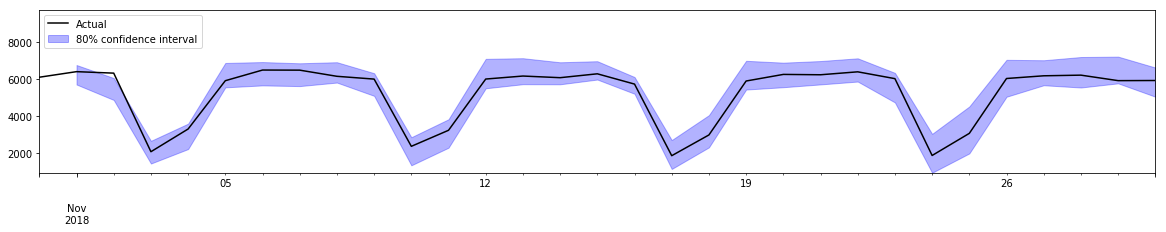

In [72]:
site_id = 33
plot_weeks = 0
confidence = 80
plot(
        predictor,
        target_ts=daily_power_consumption_per_site[site_id][start_date+30*start_date.freq:],
        plot_weeks=plot_weeks,
        confidence=confidence
    )

## Calculate some objective statistics regarding accuracy of our model

RMSE measures the "root mean square" error. It penalises more extreme "misses" and rewards consistency.
It also has the advantage that it's magnititude is proportional to the value being predicted.
MAPE measures "Mean Absolute Percentage Error". The main reason to use MAPE is that it scores errors in
percentage terms rather than as absolutes. Hence a prediciton of 11 for a value of 10 is treated identically
to a prediction of 90 for a value of 100.

In [57]:
# Gather 30 day predictions for all timeseries
predictions= []
for i, ts in enumerate(daily_power_consumption_per_site):
    # call the end point to get the 30 day prediction
    predictions.append(predictor.predict(ts=ts[start_date+30*start_date.freq:end_training])['0.5'].sum())

usages = [ts[end_training+1*start_date.freq:end_training+30*start_date.freq].sum() \
          for ts in daily_power_consumption_per_site]

for p,u in zip(predictions,usages):
    print(f'Predicted {p} kwh but usage was {u} kwh,')

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:8: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:30: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.


Predicted 37050.673339843706 kwh but usage was 35992.200000000004 kwh,
Predicted 31630.704895019604 kwh but usage was 31043.100000000002 kwh,
Predicted 29606.147521972605 kwh but usage was 29255.000000000004 kwh,
Predicted 34583.263977050796 kwh but usage was 34938.78999999999 kwh,
Predicted 30804.3096923828 kwh but usage was 30740.199999999997 kwh,
Predicted 211735.269042969 kwh but usage was 205150.09999999998 kwh,
Predicted 16336.911254882702 kwh but usage was 17890.7 kwh,
Predicted 17859.2988586422 kwh but usage was 19438.399999999998 kwh,
Predicted 30990.780883789004 kwh but usage was 30865.399999999998 kwh,
Predicted 14483.0474548341 kwh but usage was 16576.800000000003 kwh,
Predicted 32027.107604980596 kwh but usage was 32731.429999999997 kwh,
Predicted 34965.17681884769 kwh but usage was 34270.9 kwh,
Predicted 16796.6312866214 kwh but usage was 20208.000000000007 kwh,
Predicted 32588.697692871 kwh but usage was 31776.2 kwh,
Predicted 35308.55474853531 kwh but usage was 34083.0 

In [47]:
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [48]:
print(f'MAPE: {round(mape(usages, predictions),1)}%')

MAPE: 5.9%


## Remove the Endpoint (recommended)

Comment out this cell to remove the endpoint if you want the endpoint to exist after "run all"

In [73]:
sess.delete_endpoint(endpoint_name)